In [1]:
import os
import sys
#import requests
import pandas as pd
import numpy as np
from pathlib import Path

from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
# Change plot style to ggplot (for more aesthetic visualisation)
plt.style.use('ggplot')
%matplotlib inline

from IPython.core.pylabtools import figsize
figsize(16, 6)

# Supress warning in hmmlearn
import warnings
warnings.filterwarnings("ignore")

import datetime
from hmmlearn.hmm import GaussianHMM

# Read the stock data
import pandas_datareader.data as web

import logging
import itertools
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 12, 31)

fb = web.DataReader('FB', 'yahoo', start, end)
fb.columns = [col.lower() for col in fb.columns]

In [2]:
p = Path(os.getcwd()).parents[0]
# data.to_csv('{base_dir}/data-sets/AirPassengers.csv'.format(base_dir=str(p)), index=False)
data = pd.read_csv(
    '{base_dir}/data-sets/yahoofinance-stock-data.csv'.format(base_dir=str(p)), 
    index_col=0, 
    parse_dates=True, 
    infer_datetime_format=True
)
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-01-03,3.976563,4.000975,3.937500,3.984375,2.669861,41721600
1995-01-04,4.000000,4.023438,3.953125,3.976563,2.664625,41865600
1995-01-05,3.984375,4.062500,3.976563,4.007813,2.685566,60480000


In [3]:
quotes = data.copy()

# Simple model

In [4]:
# Unpack quotes
dates = np.array(quotes.index, dtype=int)
close_v = np.array(quotes.Close)
volume = np.array(quotes.Volume)[1:]

# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

# Pack diff and volume for training.
X = np.column_stack([diff, volume])

# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()


/home/dan/.pyenv/versions/condaml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dan/.pyenv/versions/condaml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dan/.pyenv/versions/condaml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dan/.pyenv

Transition matrix
[[  8.01778346e-01   1.79288184e-01   1.74552159e-02   1.47825377e-03]
 [  1.05873415e-01   8.94061108e-01   1.55560227e-08   6.54618490e-05]
 [  2.03633138e-01   2.57030482e-18   4.36523868e-01   3.59842993e-01]
 [  4.98662299e-17   1.18886256e-03   2.70991241e-02   9.71712013e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [  4.48274645e-02   6.76674167e+07]
var =  [  2.46873283e+00   4.18618272e+14]

1th hidden state
mean =  [  5.94367789e-03   4.77266765e+07]
var =  [  4.90193029e-01   1.51827104e+14]

2th hidden state
mean =  [ -6.13424542e-01   1.80532835e+08]
var =  [  6.49391735e+00   8.72915484e+15]

3th hidden state
mean =  [  3.34813647e-02   7.99622897e+07]
var =  [  7.24383849e-02   1.02020477e+15]



/home/dan/.pyenv/versions/condaml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dan/.pyenv/versions/condaml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dan/.pyenv/versions/condaml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dan/.pyenv/versions/condaml/lib/python3.6/s

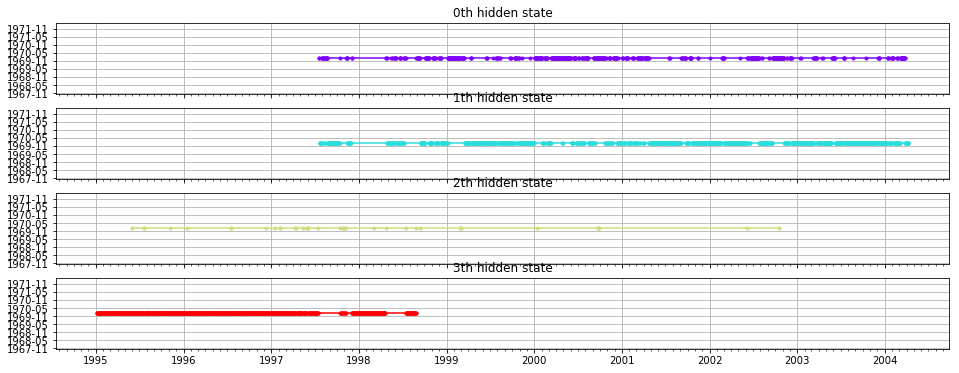

In [8]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(pd.to_datetime(dates[mask]), pd.to_datetime(close_v[mask]), ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))
    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.grid(True)
plt.show()

In [37]:
# Supress warning in hmmlearn
warnings.filterwarnings("ignore")


class StockPredictor(object):
    def __init__(self, company, stock_data, test_size=0.33, n_hidden_states=4, n_latency_days=10,
                 n_steps_frac_change=50, n_steps_frac_high=10, n_steps_frac_low=10):
        self._init_logger()

        self.company = company
        self.stock_data = stock_data
        self.n_latency_days = n_latency_days

        self.hmm = GaussianHMM(n_components=n_hidden_states)

        self._split_train_test_data(test_size)

        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)

    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)

    def _split_train_test_data(self, test_size):
        # data = pd.read_csv(
        #     'data/company_data/{company}.csv'.format(company=self.company))
        data = self.stock_data.copy()
        _train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
        self._train_data = _train_data
        self._test_data = test_data

    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['open'])
        close_price = np.array(data['close'])
        high_price = np.array(data['high'])
        low_price = np.array(data['low'])

        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price

        return np.column_stack((frac_change, frac_high, frac_low))

    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = StockPredictor._extract_features(self._train_data)
        self._logger.info('Features extraction Completed <<<')

        self.hmm.fit(feature_vector)

    def _compute_all_possible_outcomes(self, n_steps_frac_change, n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)

        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))

    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = StockPredictor._extract_features(previous_data)

        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]

        return most_probable_outcome

    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(day_index)
        return open_price * (1 + predicted_frac_change)

    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))

        if with_plot:
            test_data = self._test_data[0:days].reset_index()
            days = np.array(test_data['Date'], dtype="datetime64[ms]")
            actual_close_prices = test_data['close']

            fig = plt.figure()

            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
            axes.set_title('{company}'.format(company=self.company))

            fig.autofmt_xdate()

            plt.legend()
            plt.show()

        return pd.Series(predicted_close_prices), actual_close_prices


2019-03-26 07:45:50,513 __main__     INFO     >>> Extracting Features
2019-03-26 07:45:50,513 __main__     INFO     >>> Extracting Features
2019-03-26 07:45:50,513 __main__     INFO     >>> Extracting Features
2019-03-26 07:45:50,513 __main__     INFO     >>> Extracting Features
2019-03-26 07:45:50,518 __main__     INFO     Features extraction Completed <<<
2019-03-26 07:45:50,518 __main__     INFO     Features extraction Completed <<<
2019-03-26 07:45:50,518 __main__     INFO     Features extraction Completed <<<
2019-03-26 07:45:50,518 __main__     INFO     Features extraction Completed <<<
100%|██████████| 100/100 [04:17<00:00,  2.79s/it]


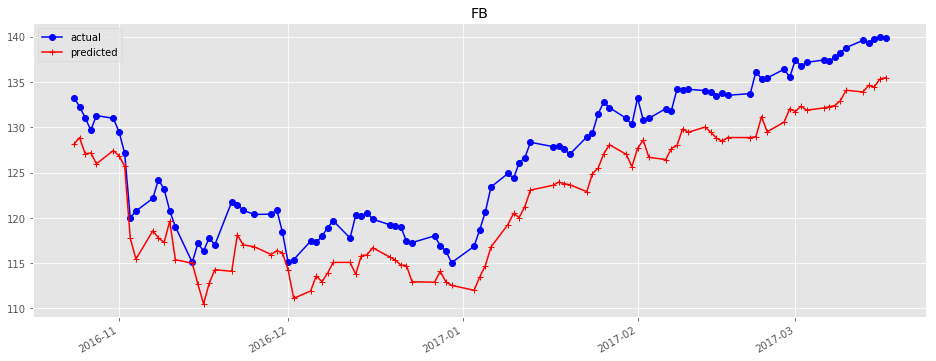

(0     128.115430
 1     128.868367
 2     127.072897
 3     127.169434
 4     125.972449
 5     127.430056
 6     126.850881
 7     125.711812
 8     117.767347
 9     115.440956
 10    118.568553
 11    117.796305
 12    117.284694
 13    119.630388
 14    115.383040
 15    114.996916
 16    112.680187
 17    110.508248
 18    112.757406
 19    114.282591
 20    114.099181
 21    118.153471
 22    117.024064
 23    116.811696
 24    115.952574
 25    116.386959
 26    116.145632
 27    114.272936
 28    111.116388
 29    111.927242
          ...    
 70    126.686781
 71    126.435792
 72    127.652087
 73    127.999598
 74    129.824026
 75    129.447557
 76    130.026732
 77    129.447557
 78    128.820099
 79    128.453293
 80    128.868367
 81    128.868367
 82    128.964904
 83    131.175448
 84    129.505473
 85    130.567301
 86    132.044218
 87    131.735328
 88    132.333813
 89    131.889780
 90    132.131107
 91    132.275897
 92    132.391729
 93    132.941960
 94    134

In [38]:
stock_predictor = StockPredictor(company='FB', stock_data=fb)
stock_predictor.fit()
stock_predictor.predict_close_prices_for_days(100, with_plot=True)